In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

seed = 420
tf.random.set_seed(seed)
np.random.seed(seed)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


5880
(266, 171)


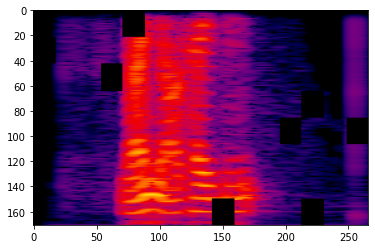

In [2]:
####################################################
################################################
import pathlib
data_dir_train = 'Dataset/audioNet1/train'
#data_dir_train = 'Dataset/audioNet0'
data_dir_train = pathlib.Path(data_dir_train)

data_dir_val = 'Dataset/audioNet1/val'
data_dir_val = pathlib.Path(data_dir_val)

data_dir_test = 'Dataset/audioNet1/test'
data_dir_test = pathlib.Path(data_dir_test)

image_count = len(list(data_dir_train.glob('*/*.png')))
print(image_count)

entry0 = list(data_dir_train.glob('0/*'))
im = Image.open(str(entry0[0]))
plt.imshow(im)
print(im.size)


In [3]:
####################################################
################################################
# Load using keras.preprocessing
batch_size = 32
img_height = 513//3
img_width = 800//3

seed = 42
validation_split = 0.15
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=seed,
            image_size=(img_height, img_width),
            batch_size=batch_size)
print()
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_val,
            seed=seed,
            image_size=(img_height, img_width),
            batch_size=batch_size)
print()
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_test,
            seed=seed,
            image_size=(img_height, img_width),
            batch_size=batch_size)

class_names = train_ds.class_names
print('\n', class_names)



Found 5880 files belonging to 24 classes.

Found 241 files belonging to 24 classes.

Found 244 files belonging to 24 classes.

 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


(32, 171, 266, 3)
(32,)


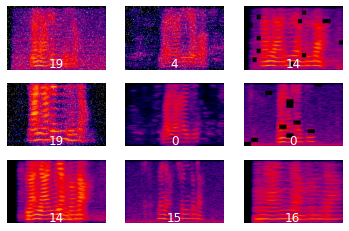

In [4]:
# Visualize the data
#plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], y=-0.06, c='w')
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    


In [5]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Create the model

num_classes = len(class_names)

norm_layer = layers.experimental.preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

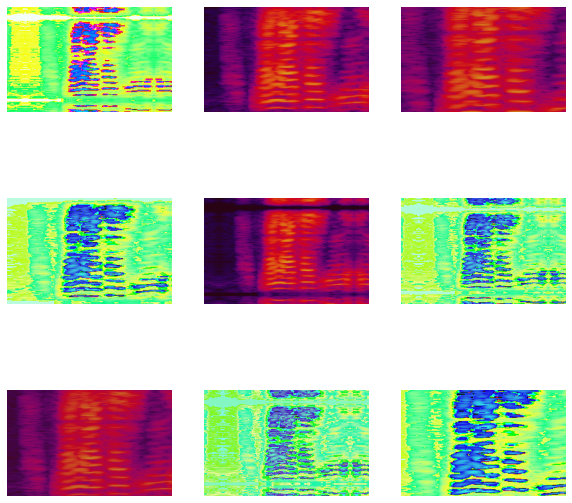

In [45]:
# Droupout on conv2D should <= 0.2
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomContrast(0.9, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ])
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [46]:

""" model = Sequential([
    #data_augmentation,
    layers.Input(shape=(img_height, img_width, 3)),
    norm_layer,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), strides=(5, 2), padding='same'),
    layers.Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    
    layers.Dropout(0.5),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), strides=(5, 2), padding='same'),
    layers.Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),

    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    layers.Dropout(0.5),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((4, 2), strides=(4, 2), padding='same'),

    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    #data_augmentation,
    norm_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), padding='same'),
    #layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), padding='same'),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((4, 2), padding='same'),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Dropout(0.25),

    layers.Reshape([17, 128]), 
    layers.Bidirectional(layers.LSTM(128)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
]) """
# 5542: loss: 0.8436 - accuracy: 0.8540
# 5524: loss: 0.8530 - accuracy: 0.8195
# 2455: loss: 1.1051 - accuracy: 0.7850

ks = (7, 2)
strides = (1, 2)
model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    norm_layer,
    #layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, ks, strides, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 1), padding='same'),
    #layers.Dropout(0.25),

    layers.Conv2D(32, ks, strides, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 1), padding='same'),
    #layers.Dropout(0.25),

    layers.Conv2D(64, ks, strides, padding='same', activation='relu'),
    layers.MaxPooling2D((4, 1), padding='same'),
    #layers.Dropout(0.25),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    #layers.Dropout(0.25),

    layers.Reshape([17, 128]), 
    layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.01))),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(tf.keras.optimizers.Adam(0.0005),#
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_22 (Sequential)   (None, 171, 266, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 171, 266, 3)       7         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 171, 133, 16)      688       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 35, 133, 16)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 35, 67, 32)        7200      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 7, 67, 32)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 34, 64)       

In [47]:
epochs=500
history = model.fit(
  train_ds,
  #steps_per_epoch=171,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=30, restore_best_weights=True)
)

model.evaluate(val_ds)


Epoch 1/500
184/184 [==============================] - 36s 181ms/step - loss: 4.3407 - accuracy: 0.0388 - val_loss: 3.4269 - val_accuracy: 0.0456
Epoch 2/500
184/184 [==============================] - 33s 178ms/step - loss: 3.3480 - accuracy: 0.0335 - val_loss: 3.2242 - val_accuracy: 0.0373
Epoch 3/500
184/184 [==============================] - 33s 178ms/step - loss: 3.2123 - accuracy: 0.0415 - val_loss: 3.1904 - val_accuracy: 0.0456
Epoch 4/500
184/184 [==============================] - 33s 178ms/step - loss: 3.1886 - accuracy: 0.0458 - val_loss: 3.1829 - val_accuracy: 0.0415
Epoch 5/500
184/184 [==============================] - 33s 180ms/step - loss: 3.1815 - accuracy: 0.0372 - val_loss: 3.1768 - val_accuracy: 0.0581
Epoch 6/500
184/184 [==============================] - 32s 171ms/step - loss: 3.1788 - accuracy: 0.0494 - val_loss: 3.1712 - val_accuracy: 0.0498
Epoch 7/500
184/184 [==============================] - 31s 171ms/step - loss: 3.1291 - accuracy: 0.0690 - val_loss: 2.7855 -

[0.4825478792190552, 0.9211618304252625]

In [48]:
print('Evaluating on Test set......')
model.evaluate(test_ds)


Evaluating on Test set......
8/8 [==============================] - 1s 50ms/step - loss: 1.0146 - accuracy: 0.8566


[1.0146199464797974, 0.8565573692321777]

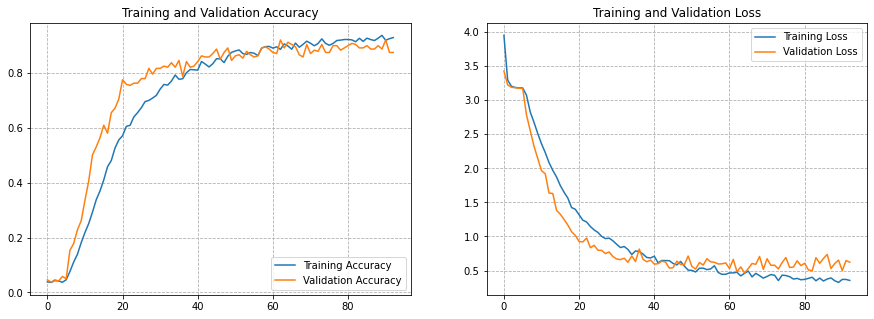

In [49]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(ls='--')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid(ls='--')
plt.title('Training and Validation Loss')
plt.show()


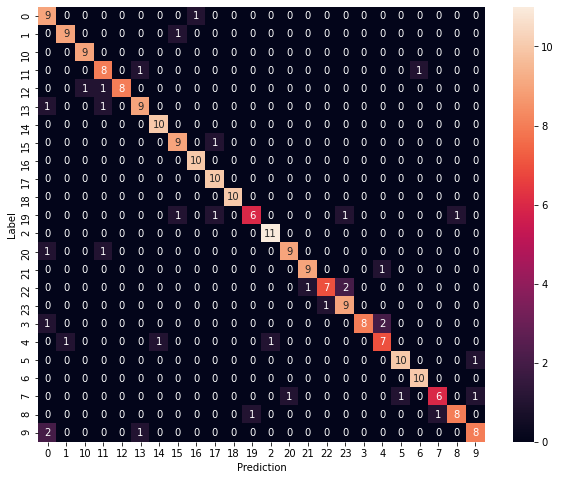

In [50]:
import seaborn as sns

y_true = np.array([i[1] for i in test_ds.unbatch().as_numpy_iterator()])
y_pred = np.argmax(model.predict(test_ds), axis=1)
# y_pred = np.array([i[0] for i in test_ds.unbatch().as_numpy_iterator()])

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [51]:
model.save('model/audioNet')



INFO:tensorflow:Assets written to: model/audioNet/assets


INFO:tensorflow:Assets written to: model/audioNet/assets


In [ ]:
import os
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

fp = 'Dataset\\audioNet'

for fond in os.listdir(fp):
    for pic in os.listdir(os.path.join(fp, fond)):
        if 'aug' in pic: continue
        img = imageio.imread(os.path.join(fp, fond, pic))#[:,:,:3]
        #aug = iaa.Salt(0.05)#AdditivePoissonNoise((20, 40))
        aug = iaa.CoarseDropout((0.05, 0.1), size_percent=(0.05, 0.1))
        image_aug = aug(image=img)
        #ia.imshow(img)
        #ia.imshow(image_aug)

        fname = os.path.splitext(pic)[0] + '_aug1' + os.path.splitext(pic)[1]
        imageio.imsave(os.path.join(fp, fond, fname), image_aug)
        #break
    print(fond)
    #break
